<a href="https://colab.research.google.com/github/scigeek72/GNN_Repo/blob/main/practice_2_GNN_graphsage_no_edge_attr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is not my implementation. I am merely copying it from another notebook to get some practice about how GNNs are implemented.

In [3]:
# Install torch geometric
!pip install torch-scatter -f https://data.pyg.org/wh1/torch-1.11.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/wh1/torch-1.11.0+cu113.html
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/wh1/torch-1.11.0+cu113.html
  Created wheel for torch-scatter: filename=torch_scatter-2.0.9-cp37-cp37m-linux_x86_64.whl size=3567071 sha256=ec67ef0778326b93f6065adf63f63e1328262874b00c6fda6848d68ede9f7e3d
  Stored in directory: /root/.cache/pip/wheels/dd/57/a3/42ea193b77378ce634eb9454c9bc1e3163f3b482a35cdee4d1
Successfully built torch-scatter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/wh1/torch-1.11.0+cu113.html
     |████████████████████████████████| 51 kB 236 kB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=1703243 sha256=0e11b0fbdc403d93224d4b7162141c5a16da5df65fa811663a2f332cb7133bf6
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully

In [4]:
# Imports
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import negative_sampling
from tqdm import trange

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
device

device(type='cuda')

# Get the OGB drug-drug interaction (DDI) dataset

In [7]:
from os import name
from ogb.linkproppred import PygLinkPropPredDataset

dataset_name = 'ogbl-ddi'

dataset = PygLinkPropPredDataset(name= dataset_name)

print(f'The {dataset_name} dataset has {len(dataset)} graph(s)')

Downloaded 0.04 GB: 100%|██████████| 46/46 [00:00<00:00, 59.22it/s]


Extracting dataset/ddi.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 36.09it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2832.08it/s]

Saving...
The ogbl-ddi dataset has 1 graph(s)



Done!


To get more info about the dataset, look at https://ogb.stanford.edu/docs/linkprop/#ogbl-ddi 

A graph is represented as $G = (V, E)$, where $V$ is the set of nodes, and $v \in V$ is an individual node. $E$ is the set of edges. In torch-geometric, $E$ is represented as `edge_index` in the `COO` format (which has a shape [2, |E|] ). 

The first row of `edge_index` contains all the `src_nodes` and the second row contains the corresponding `dest_nodes`. 

** IN THE CASE OF UNDIRECTED GRAPHS, `edge_index` has shape [2, 2$×$|E|] **



In [8]:
ddi_graph = dataset[0]

In [9]:
print(f'DDI graph object: {ddi_graph}')
print(f'Number of nodes, |V|: {ddi_graph.num_nodes}')
print(f'Number of (training) edges |E|: {ddi_graph.num_edges}')
print(f'Is undirected? {ddi_graph.is_undirected()}')
print(f'Average node degree: {ddi_graph.num_edges/ddi_graph.num_nodes:.2f}')
print(f'Number of Node Features: {ddi_graph.num_node_features}')
print(f'Number of Edge Features: {ddi_graph.num_edge_features}')
print(f'Has isolated Nodes: {ddi_graph.has_isolated_nodes()}')
print(f'Has self-loops: {ddi_graph.has_self_loops()}')

DDI graph object: Data(num_nodes=4267, edge_index=[2, 2135822])
Number of nodes, |V|: 4267
Number of (training) edges |E|: 2135822
Is undirected? True
Average node degree: 500.54
Number of Node Features: 0
Number of Edge Features: 0
Has isolated Nodes: False
Has self-loops: False


In order to explore this graph(s) with more graph related metrics, such as if it is connected? If no, how many components does it have? What are the average shortest-path lengths for each component? What's the diameter of each compnenet? etc, convert the `ddi_graph` to a `networkx` graph. `networkx` has richer set of functions that lets us do these. torch_geometric has a utility `(to_networkx)` to directly convert it to a `networkx` graph.  

For `graphsage` algorithm, we need `positive edges` and sample `negative edges` (to compute the loss function, look at the paper [Inductive representation learning on graphs](https://arxiv.org/abs/1706.02216?context=cs) by Leskovec et.al). 

 - **Positive Edges** are the edges that exist in the graph. That is, the set { ($u$,$v$) $\in$ $E$, where $u$ and $v$ $\in$ $V$ }
 - **Negative Edges** edges don't exist in the graph, that is, { ($u$,$v$) $\notin$ $E$ where $u$ and $v$ $\in$ $V$ } 
  
  - Note: I need to see if that is the definition provided by the authors in the above paper
  - torch-geometric has a utility `NegativeSampler` which can be used to get **negative edges**

**Note: For this excercise, we don't need to use `NegativeSample` as torch_geometric has already provided these for us. But for creating my own dataset, we need it.

In [10]:
split_edges = dataset.get_edge_split()
train_edges, valid_edges, test_edges = split_edges['train'], split_edges['valid'], split_edges['test']

In [11]:
print(f'Number of training positive edges: {len(train_edges["edge"])}')
print(f'Number of validation positive edges: {len(valid_edges["edge"])}')
print(f'Number of test positive edges: {len(test_edges["edge"])}')
print(f"====================================")
print(f'Number of validation negative edges: {len(valid_edges["edge_neg"])}')
print(f'Number of test negative edges: {len(test_edges["edge_neg"])}')

Number of training positive edges: 1067911
Number of validation positive edges: 133489
Number of test positive edges: 133489
Number of validation negative edges: 101882
Number of test negative edges: 95599


**NOTE** Although PyG has provided the negative edges for validation and test set, while training we also need to sample negative edges (to compute the loss function).

#Graphical Neural Network (GNN)

**GNN** relies on the concept of *message passing*. For each node $v$, 'information' from it's neighboring nodes (denoted by $\mathcal{N}(v) = \{u, \text{such that } (v,u) \in E\}$) are passed to the node $v$ as messages where these messages are aggregated (using 'a permutation-invariant function'). After aggregation, the 'representation' of the node $v$, usually denoted by $h_v$, is updated.   

For implementation, we should keep in mind the following. Each layer of a GNN has 3 components.

 - **Message passing** between a node and it's neighbor
 - **Aggregation** of the received messages at each node
 - **Updating** of a node's representation after **aggregation**

 
For the $l$-th layer, let $h_v^{l}$ be the vector representation of the node $v$. For the $(l+1)$-th layer,    each message between $v$ and $u$, where $u \in \mathcal{N}(v)$, $m_{vu}$ is aggregated (denoted by AGGR) at node $v$, and then $h_v^{l}$ is updated (denoted by UPDATE) to get the representation for the next layer ($l+1$) and so on. 

In mathematical language, the above procedure is described as follows:

$$h_v^{l+1} = UPDATE(h_v^l, AGGR(\{m_{vu}^{l+1}, ∀u \in \mathcal{N}(v)\}))$$

$m_{vu}$ are the messages, for a layer, from the neighbors. Many different GNN models employes different message skims. 

For the GraphSAGE model that we are going to use, the messages are given by $$m_{vu}^{l+1} = h_u^l, \forall u \in \mathcal{N}(v)$$ It takes into consideration only the node representation of the neighboring nodes. 

AGGR is simply the function `mean` (note, this is a permutation-invariant function). UPDATE is simply adding these aggregated messages to $h_v^l$. 

Mathematically, $$h_v^{l+1} = W_1 . h_v^l + W_2 . mean(\{m_{vu}, \forall u \in \mathcal{N}(v)\})$$

Note that $W_1,W_2$ are learnable weights. 

Note that, the sizes of matrices $W_1$ and $W_2$ are such that after each multiplication, the **output dimensions must match the dimension of the output vector for that layer**. In this particular implementation, since all layers have same dimensions, the products should be equal to hidden_channels. 

For implementation, these can be achieved by a traditional neural net layers (torch.nn.Linear layer).

Note: A crucial difference between our case and this case is that each node is assumed to have node features and no edge features. 



In [12]:
class GraphSAGE(torch.nn.Module):

  def __init__(self,conv,in_channels, hidden_channels, out_channels, num_layers, dropout):
    super(GraphSAGE,self).__init__()

    self.convs = torch.nn.ModuleList() ## just like list, to keep the layers
    # add a convolutional layer. Out dimension of one layer must be the input dimension of the next layer
    # Apply $L2$ normalization to the node representation after each layer
    # conv is a place-holder for different convolutioanal models. For now, we will use PyG's SAGEConv implementation
    # but later we will implement our own, custom, convolutional layers
    # For the first layer, input has shape (|V|, in_channels), where in_channels = dim of the node features
    self.convs.append(conv(in_channels,hidden_channels,normalize=True))
    # For layer k=1 to (K-2), input shape:(|V|,hidden_channels), output shape: (|V|,hidden_channels)
    for l in range(num_layers-2):
      self.convs.append(conv(hidden_channels,hidden_channels,normalize = True))
    # For the last layer, i,e (K-1)th layer, input_shape = hidden_channels, output_shape = out_channels
    self.convs.append(conv(hidden_channels, out_channels, normalize=True))

    self.num_layers = num_layers
    self.dropout = dropout

  
  def forward(self, x, edge_index):
    # x is the initial node features 
    for i in range(self.num_layers-1):
      # conducts message passing, aggregation and updates for layer i
      # x hold the same info as $h_v^l$ in the above explanation
      x = self.convs[i](x, edge_index)
      # when i = 0, x has shape [|V|, in_channels]
      # for i>0, x has shape [|V|, hidden_channels]
      # Pass through a non-linearity
      x = F.relu(x)
      # dropout is applied to the weight matrices (W_1, and W_2) in the above equation
      x = F.dropout(x, p=self.dropout, training=self.training) # not sure about this line of code
    
    # Final layer, generate node embeddings 
    x = self.convs[self.num_layers-1](x, edge_index)

    return x 


  



Note that, as mentioned above, drugs, i,e nodes in this case, do not have features. To amend this, they randomly initialized node features using `torch.nn.Embedding` layer.

In [13]:
# parameters for the above model
graphsage_in_channels = 256
graphsage_hidden_channels = 128
graphsage_out_channels = 256
graphsage_num_layers = 2
dropout = 0.5 

In [14]:
initial_node_embeddings = torch.nn.Embedding(ddi_graph.num_nodes, graphsage_in_channels).to(device)

In [15]:
# Initialize our model
graphsage_model = GraphSAGE(
    SAGEConv, graphsage_in_channels,
    graphsage_hidden_channels,
    graphsage_out_channels,
    graphsage_num_layers,
    dropout
).to(device)

At this point, the model will produce, (after training which we haven't described as yet), the final embeddings of each node. The final tensor will have size (|V|, graphsage_out_channels). 

## DownStrem task (Link Prediction)

Now we can take these embeddings and can use them in some downstream tasks. For this present work, it is link predictions, i,e, the task is to predict, given two new drugs, the probability that there will be interaction between the two drugs if taken together? To perform this, we need to define a link predictor. Below we will do that before going to describe training procedure.




In [16]:
#link predictor parameters
link_predictor_in_channels = graphsage_out_channels
link_predictor_hidden_channels = link_predictor_in_channels

# it has binary output (wheather link exists or not)

Below we will describe the LinkPredictor class, which will take into account the hadamard (elementwise) product of node representations of nodes $u$ and $v$, that is, $h_v^K$ and $h_u^K$ as $h_v^K ∘ h_u^K$, and pass it through a traditional deep neural network. 

In [17]:
class LinkPredictor(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, dropout, out_channels=1, el_prod=lambda x,y: x*y):
    super(LinkPredictor, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(in_channels, hidden_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout),
        nn.Linear(hidden_channels, out_channels),
        nn.Sigmoid()
    )

    self.el_prod = el_prod

  def forward(self, u, v):
    x = self.el_prod(u,v)
    return self.model(x)


In [18]:
link_predictor = LinkPredictor(link_predictor_in_channels,link_predictor_hidden_channels,dropout).to(device)

Now that we have built our models (GNN + LinkPredictor), we need to train these models. Below we will write a training method that will train the models. 

Since the downstream link prediction task is a binary output task, we will use `binary crossengropy` for our loss function. However, if the downstream task is different, we need to use the appropriate loss function.


In [19]:
from typing import ItemsView
def train(graphsage_model, link_predictor, initial_node_embeddings,edge_index, pos_train_edges,
          optimizer,batch_size):
  total_loss, total_examples = 0,0 # in our case, we only output the loss as in other cases shown

  # set our model to train (this two lines below is not clear, since we haven't written any train method for them)
  graphsage_model.train()
  link_predictor.train()

  # Iterate over batches of training edges (positive edges)
  # pos edge samples are contained in a Tensor of shape [2, batch_size]
  # For sending batches of data, we will use pytorch's DataLoader method

  for pos_samples in DataLoader(pos_train_edges, batch_size, shuffle=True):

    # set the gradients to zeros
    optimizer.zero_grad()

    # run graphsage forward pass
    node_embeddings = graphsage_model(initial_node_embeddings, edge_index) # h_v in the theory above

    # sample batch_size negative edges; size = [2, batch_size]
    neg_samples = negative_sampling(edge_index,
                                    num_nodes=initial_node_embeddings.shape[0],
                                    num_neg_samples= len(pos_samples),
                                    method = 'dense'
                                    ) 
    
    # run linkPredictor forward pass on positive edge embeddings
    pos_preds = link_predictor(node_embeddings[pos_samples[:,0]],
                               node_embeddings[pos_samples[:,1]])
    
    # run linkPredictor forward pass on negative edge embeddings
    neg_preds = link_predictor(node_embeddings[neg_samples[0]],
                               node_embeddings[neg_samples[1]])
    
    preds = torch.concat((pos_preds, neg_preds))
    labels = torch.concat((torch.ones_like(pos_preds),
                           torch.zeros_like(neg_preds)))
    
    loss = F.binary_cross_entropy(preds,labels)

    loss.backward()
    optimizer.step()

    num_examples = len(pos_preds)
    total_loss += loss.item() * num_examples
    total_examples += num_examples

    return total_loss/total_examples






In [20]:
#@title Training Parameter
lr = 0.005 #@param {type: 'number'}
batch_size = 65536 #@param {type:'number'}
epochs = 50 #@param {type: 'number'}
eval_steps = 5 #@param {type: 'number'}

In [21]:
optimizer = torch.optim.Adam(list(graphsage_model.parameters()) + list(initial_node_embeddings.parameters())+list(link_predictor.parameters()),lr=lr)

# Evaluation (Task specific)

In [22]:
pos_valid_edges = valid_edges['edge'].to(device)
neg_valid_edges = valid_edges['edge_neg'].to(device)
pos_test_edges = test_edges['edge'].to(device)
neg_test_edges = test_edges['edge_neg'].to(device)

For this link prediction, evaluation is done via a metric called 'Hits'. For definition, look at the original reference code. 

In [23]:
from ogb.linkproppred import Evaluator

evaluator = Evaluator(name=dataset_name)

In [24]:
@torch.no_grad()
def test(graphsage_model, link_predictor, initial_node_embeddings, edge_index, 
         pos_valid_edges,neg_valid_edges, pos_test_edges, neg_test_edges, batch_size, evaluator):
  
  # run graphsage forward pass
  final_node_embeddings = graphsage_model(initial_node_embeddings, edge_index)

  # run link_predictor forward pass on positive validation edge embeddings
  pos_valid_preds = []
  
  for pos_samples in DataLoader(pos_valid_edges, batch_size):
    pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],
                               final_node_embeddings[pos_samples[:,1]])
    
    pos_valid_preds.append(pos_preds.squeeze()) # look up squeeze()

  pos_valid_pred = torch.cat(pos_valid_preds, dim=0) # difference between torch.concat and torch.cat ?

  # run link_predictor forward pass on negative validation edge embeddings
  neg_valid_preds = []

  for neg_samples in DataLoader(neg_valid_edges, batch_size):
    neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],
                               final_node_embeddings[neg_samples[:,1]])
    neg_valid_preds.append(neg_preds.squeeze()) # look up squeeze()
  
  neg_valid_pred = torch.cat(neg_valid_preds, dim=0)

# run link_predictor forward pass on positive test edge embeddings
  pos_test_preds = []
  
  for pos_samples in DataLoader(pos_test_edges, batch_size):
    pos_preds = link_predictor(final_node_embeddings[pos_samples[:,0]],
                               final_node_embeddings[pos_samples[:,1]])
    
    pos_test_preds.append(pos_preds.squeeze()) # look up squeeze()

  pos_test_pred = torch.cat(pos_test_preds, dim=0) # difference between torch.concat and torch.cat ?

  # run link_predictor forward pass on negative test edge embeddings
  neg_test_preds = []

  for neg_samples in DataLoader(neg_test_edges, batch_size):
    neg_preds = link_predictor(final_node_embeddings[neg_samples[:,0]],
                               final_node_embeddings[neg_samples[:,1]])
    neg_test_preds.append(neg_preds.squeeze()) # look up squeeze()
  
  neg_test_pred = torch.cat(neg_test_preds, dim=0)


  # Calculate Hits20
  evaluator.K = 20
  valid_hits = evaluator.eval({'y_pred_pos': pos_valid_pred, 'y_pred_neg': neg_valid_pred})
  test_hits = evaluator.eval({'y_pred_pos': pos_test_pred, 'y_pred_neg': neg_test_pred})

  return valid_hits, test_hits


Run the training and evaluation

Loss 0.6890:  10%|█         | 5/50 [00:07<01:00,  1.34s/it]


Epoch:5,Validation Hits@20:0.0002,Test Hits@20:0.0001


Loss 0.6567:  20%|██        | 10/50 [00:11<00:48,  1.22s/it]


Epoch:10,Validation Hits@20:0.0002,Test Hits@20:0.0001


Loss 0.5888:  30%|███       | 15/50 [00:15<00:37,  1.06s/it]


Epoch:15,Validation Hits@20:0.0004,Test Hits@20:0.0003


Loss 0.5185:  40%|████      | 20/50 [00:20<00:34,  1.16s/it]


Epoch:20,Validation Hits@20:0.0001,Test Hits@20:0.0003


Loss 0.4665:  50%|█████     | 25/50 [00:24<00:25,  1.01s/it]


Epoch:25,Validation Hits@20:0.0002,Test Hits@20:0.0003


Loss 0.4423:  60%|██████    | 30/50 [00:28<00:21,  1.06s/it]


Epoch:30,Validation Hits@20:0.0003,Test Hits@20:0.0003


Loss 0.4238:  70%|███████   | 35/50 [00:33<00:17,  1.19s/it]


Epoch:35,Validation Hits@20:0.0002,Test Hits@20:0.0004


Loss 0.4105:  80%|████████  | 40/50 [00:37<00:10,  1.02s/it]


Epoch:40,Validation Hits@20:0.0005,Test Hits@20:0.0005


Loss 0.3863:  90%|█████████ | 45/50 [00:41<00:05,  1.11s/it]


Epoch:45,Validation Hits@20:0.0003,Test Hits@20:0.0003


Loss 0.3720: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


Epoch:50,Validation Hits@20:0.0003,Test Hits@20:0.0005


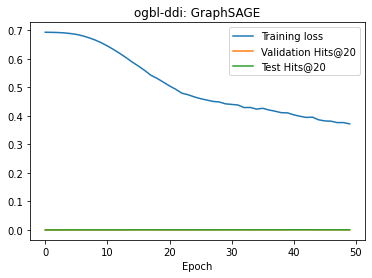

In [25]:
import matplotlib.pyplot as plt

epochs_bar = trange(1,epochs+1, desc='Loss n/a')

edge_index = ddi_graph.edge_index.to(device)
pos_train_edges = train_edges['edge'].to(device)

losses = []
valid_hits_list = []
test_hits_list = []

for epoch in epochs_bar:
  loss = train(graphsage_model, link_predictor, initial_node_embeddings.weight,edge_index, 
               pos_train_edges, optimizer, batch_size)
  losses.append(loss)

  epochs_bar.set_description(f'Loss {loss:0.4f}')

  if epoch % eval_steps == 0:
    valid_hits, test_hits = test(graphsage_model, link_predictor, initial_node_embeddings.weight,
                                 edge_index,
                                 pos_valid_edges, pos_test_edges,
                                 neg_valid_edges,neg_test_edges,
                                 batch_size, evaluator)
    
    print(f'\nEpoch:{epoch},Validation Hits@20:{valid_hits["hits@20"]:0.4f},Test Hits@20:{test_hits["hits@20"]:0.04f}')

    valid_hits_list.append(valid_hits["hits@20"])
    test_hits_list.append(test_hits["hits@20"])
  else:
    valid_hits_list.append(valid_hits_list[-1] if valid_hits_list else 0)
    test_hits_list.append(test_hits_list[-1] if test_hits_list else 0)

plt.title(dataset.name + ": GraphSAGE")
plt.xlabel("Epoch")
plt.plot(losses, label = "Training loss")
plt.plot(valid_hits_list, label = "Validation Hits@20")
plt.plot(test_hits_list, label = "Test Hits@20")
plt.legend()
plt.show()

tensor([[4039, 2424, 4039,  ...,  338,  835, 3554],
        [2424, 4039,  225,  ...,  708, 3554,  835]])